In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from sklearn.utils.validation import check_is_fitted, check_array
%matplotlib inline
import seaborn as sns

In [2]:
data = pd.read_csv(   'https://raw.githubusercontent.com/Garve/datasets/4576d323bf2b66c906d5130d686245ad205505cf/mmm.csv',
    parse_dates=['Date'],
    index_col='Date'
)
X = data.drop(columns=['Sales'])
y = data['Sales']

## Creating a Saturation Effect

a = hyperparameter controling shape of saturation curve (a>0)

X = spend

saturation effect = 1-exp(a*X)

In [52]:
class SaturationEffect(BaseEstimator,TransformerMixin):
    def __init__(self,a=.0010):
        if a > 0:
            self.a = a
        else:
            self.a = 1
    def fit(self,X,y=None):
        X = check_array(X)
        self._check_n_features(X,reset=True)
        return self
    def transform(self,X):
        check_is_fitted(self)
        X = check_array(X)
        self._check_n_features(X,reset=False)

        return 1 - np.exp(-self.a*X)

In [53]:
spend_df = data.copy()
spend_df.drop(columns=list(data.columns)[0:4],inplace=True)
spend_df["Spend_total"] = data["TV"]+data["Radio"]+data["Banners"]
spend_df

,Spend_total
Date,
2018-01-07,13528.10
2018-01-14,7568.58
2018-01-21,6282.82
2018-01-28,3562.21
2018-02-04,2187.29
...,...
2021-10-03,1691.68
2021-10-10,18677.81
2021-10-17,6475.35


In [54]:
SE = SaturationEffect()
spend_df["Saturated_spends"] = SE.fit_transform(spend_df[["Spend_total"]])
spend_df

,Spend_total,Saturated_spends
Date,,
2018-01-07,13528.10,0.999999
2018-01-14,7568.58,0.999484
2018-01-21,6282.82,0.998132
2018-01-28,3562.21,0.971624
2018-02-04,2187.29,0.887780
...,...,...
2021-10-03,1691.68,0.815790
2021-10-10,18677.81,1.000000
2021-10-17,6475.35,0.998459


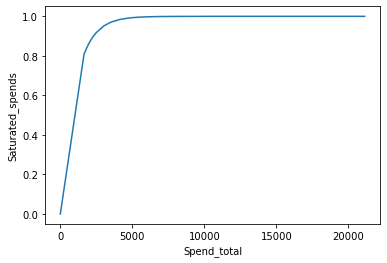

In [55]:
sns.lineplot(x=spend_df["Spend_total"],y=spend_df["Saturated_spends"]);

## Carry-Over Effect

In [56]:
from scipy.signal import convolve2d
import numpy as np
class ExponentialCarryover(BaseEstimator, TransformerMixin):
    def __init__(self, strength=0.5, length=1):
        self.strength = strength
        self.length = length
    def fit(self, X, y=None):
        X = check_array(X)
        self._check_n_features(X, reset=True)
        self.sliding_window_ = (
            self.strength ** np.arange(self.length + 1)
        ).reshape(-1, 1)
        return self
    def transform(self, X: np.ndarray):
        check_is_fitted(self)
        X = check_array(X)
        self._check_n_features(X, reset=False)
        convolution = convolve2d(X, self.sliding_window_)
        if self.length > 0:
            convolution = convolution[: -self.length]
        return convolution

In [61]:
CE = ExponentialCarryover()
spend_df["Carried_spends"] = CE.fit_transform(spend_df[["Spend_total"]])
spend_df

,Spend_total,Saturated_spends,Carried_spends
Date,,,
2018-01-07,13528.10,0.999999,13528.100
2018-01-14,7568.58,0.999484,14332.630
2018-01-21,6282.82,0.998132,10067.110
2018-01-28,3562.21,0.971624,6703.620
2018-02-04,2187.29,0.887780,3968.395
...,...,...,...
2021-10-03,1691.68,0.815790,4070.670
2021-10-10,18677.81,1.000000,19523.650
2021-10-17,6475.35,0.998459,15814.255


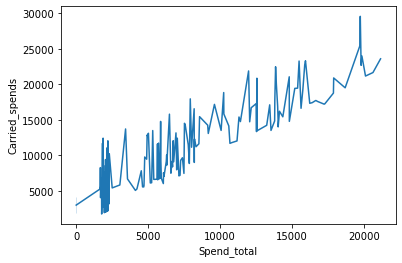

In [62]:
sns.lineplot(x=spend_df["Spend_total"],y=spend_df["Carried_spends"]);

## Pipeline

In [57]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

In [59]:
adstock = ColumnTransformer(
    [
     ('tv_pipe', Pipeline([
                           ('carryover', ExponentialCarryover()),
                           ('saturation', SaturationEffect())
     ]), ['TV']),
     ('radio_pipe', Pipeline([
                           ('carryover', ExponentialCarryover()),
                           ('saturation', SaturationEffect())
     ]), ['Radio']),
     ('banners_pipe', Pipeline([
                           ('carryover', ExponentialCarryover()),
                           ('saturation', SaturationEffect())
     ]), ['Banners']),
    ],
    remainder='passthrough'
)
model = Pipeline([
                  ('adstock', adstock),
                  ('regression', LinearRegression())
])